# ELO

In [176]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
import pendulum
import seaborn as sns
import statsmodels.api as sm
import warnings

warnings.filterwarnings('ignore')
import utils

In [162]:
class Game:
    def __init__(self, dt, game_id, home, away, home_mov, home_elo=None, away_elo=None,point_spread=None,homefield=100,k=22):
        self.game_id = game_id
        self.dt = dt
        self.home = home
        self.away = away
        self.home_mov = home_mov
        self.point_spread = point_spread
        
        self.home_elo = home_elo
        self.away_elo = away_elo
        
        
        self.homefield = homefield
        self.k = k
    
    def _get_q(self, elo):
        q = 10 ** (elo / 400)
        
        return q
    
    def get_home_expectation(self):
        home_elo = self.home_elo + self.homefield
        
        expectation = (
            self._get_q(home_elo) / (self._get_q(self.away_elo) + self._get_q(home_elo))
        )
        
        return expectation
    
    def UpdateElo(self):
        if self.get_home_expectation() >= 0.5 and self.home_mov > 0:
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation())
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation())
        
        elif self.get_home_expectation() >= 0.5 and self.home_mov < 0:
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation())
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation())
        
        elif self.get_home_expectation() < 0.5 and self.home_mov < 0:
            self.home_elo = self.home_elo - self.k * (self.get_home_expectation())
            self.away_elo = self.away_elo + self.k * (self.get_home_expectation())
        
        elif self.get_home_expectation() < 0.5 and self.home_mov > 0:
            self.home_elo = self.home_elo + self.k * (1 - self.get_home_expectation())
            self.away_elo = self.away_elo - self.k * (1 - self.get_home_expectation())
            
def clean_br_date(input_string):
    day_of_week, raw_month, raw_date, raw_year = input_string.split(' ')
    if raw_month == 'Dec':
        month = 12
    elif raw_month == 'Jan':
        month = 1
    elif raw_month == 'Feb':
        month = 2
    elif raw_month == 'Mar':
        month = 3
    elif raw_month == 'Apr':
        month = 4
    elif raw_month == 'May':
        month = 5
        
    year = int(raw_year)
    day = int(raw_date)
    
    return pendulum.Date(year, month, day)

def get_elo(team, elos):
    elo = (
        elos
        .query(f'team == "{team}"')
        .sort_values(by='dt', ascending=False)
        .elo
        .tolist()
        [0]
    )
    
    return elo

In [163]:
df = pd.read_csv('../data/NBA Scores and Point Spreads.csv')

games = (
    df
    .query('game_number <= 82')
    .query('season >= "2008-09"')
    .query('home_away == "Home"')
    [['game_id', 'season', 'dt', 'team', 'opponent', 'mov', 'point_spread', 'game_number']]
    .rename(
        columns={
            'team': 'home',
            'opponent': 'away',
            'mov': 'home_mov'
        }
    )
    .sort_values(
        by=['season', 'dt', 'home']
    )
    .assign(
        dt = lambda x: x['dt'].apply(utils.clean_date)
    )
)

games.tail(10)

,game_id,season,dt,home,away,home_mov,point_spread,game_number
36017,ea48985bdcb918f19a9a443bd9e2cdd3,2022-23,2022-12-10,Miami,SanAntonio,-4,-12.0,27.0
36283,dc6dec95fe5845c04a5ee941b9114ea2,2022-23,2022-12-10,Portland,Minnesota,6,-5.5,26.0
36417,ea252a4d92c55b786f23138cb671412d,2022-23,2022-12-10,Washington,LAClippers,-7,5.0,27.0
35642,bbb7141a0ef6c522272d91108bbca97d,2022-23,2022-12-11,Atlanta,Chicago,1,-3.5,27.0
35830,47b2efcef107631e33fb88415265d618,2022-23,2022-12-11,Detroit,LALakers,-7,5.0,29.0
35883,2821a94f38d661ae7edfa86e8a50325b,2022-23,2022-12-11,Houston,Milwaukee,5,10.0,26.0
36123,879e6ade0daa4d622ed9ccc61477f1c6,2022-23,2022-12-11,NewOrleans,Phoenix,5,-3.5,26.0
36150,1d6f3ae7deea41c203d3e71544206b05,2022-23,2022-12-11,NewYork,Sacramento,13,-2.5,27.0
36204,380ac405ac1f057627885807fe70ecf2,2022-23,2022-12-11,Orlando,Toronto,12,6.5,28.0
36230,0b03297c101c3e8cfd5eaaf0b3f5ef4d,2022-23,2022-12-11,Philadelphia,Charlotte,18,-10.5,26.0


In [164]:
teams = games.home.unique().tolist()

elos = pd.DataFrame(
    {
        'team': teams,
        'elo': np.repeat(1500, len(teams)),
        'dt': np.repeat(pendulum.Date(2007,10,31), len(teams))
    }
)

elos.tail()

,team,elo,dt
25,Indiana,1500,2007-10-31
26,Milwaukee,1500,2007-10-31
27,Nets,1500,2007-10-31
28,NewOrleans,1500,2007-10-31
29,Sacramento,1500,2007-10-31


## Run Simulation

In [165]:
rows = []

for raw in games.to_dict('records'):
    game = Game(home=raw['home'], away=raw['away'], dt=raw['dt'], home_mov=raw['home_mov'], point_spread=raw['point_spread'], game_id=raw['game_id'])
    game.home_elo = get_elo(game.home, elos)
    game.away_elo = get_elo(game.away, elos)
    
    # Pre-game info
    
    row = {
        'game_id': game.game_id,
        'home': game.home,
        'away': game.away,
        'home_elo': game.home_elo,
        'away_elo': game.away_elo,
        'home_mov': game.home_mov,
        'point_spread': game.point_spread,
        'dt': game.dt,
    }
   
    game.UpdateElo()
    home_update = {
        'team': game.home,
        'elo': game.home_elo,
        'dt': game.dt
    }
    
    elos = elos.append(home_update, ignore_index=True)

    away_update = {
        'team': game.away,
        'elo': game.away_elo,
        'dt': game.dt
    }
    
    
    # Write to database: Elos
    elos = elos.append(away_update, ignore_index=True)
    
    # Write to database: Pre and Post Game elos, plus game result and point spread.
    post_game_update = {
        'home_elo__post': game.home_elo,
        'away_elo__post': game.away_elo,
    }

    row.update(post_game_update)
    
    rows.append(row)

## Review

In [166]:
dates = elos.dt.unique().tolist()

final = (
    pd.DataFrame({'dt': dates})
    .merge(
        pd.DataFrame({'team': teams}),
        how='cross'
    )
    .assign(
        dummy='dummy'
    )
    .merge(
        elos,
        on=['dt', 'team'],
        how='left'
    )
    .assign(
        elo = lambda x: x.groupby('team')['elo'].transform(lambda s: s.ffill())
    )
    .merge(
        (
            games
            [['season', 'dt']]
            .drop_duplicates()
        ),
        on='dt',
        how='left'
    )
)

final.tail()

,dt,team,dummy,elo,season
67526,2022-12-11,Indiana,dummy,1400.838780,2022-23
67527,2022-12-11,Milwaukee,dummy,1614.793938,2022-23
67528,2022-12-11,Nets,dummy,1540.109642,2022-23
67529,2022-12-11,NewOrleans,dummy,1571.680021,2022-23
67530,2022-12-11,Sacramento,dummy,1485.619634,2022-23


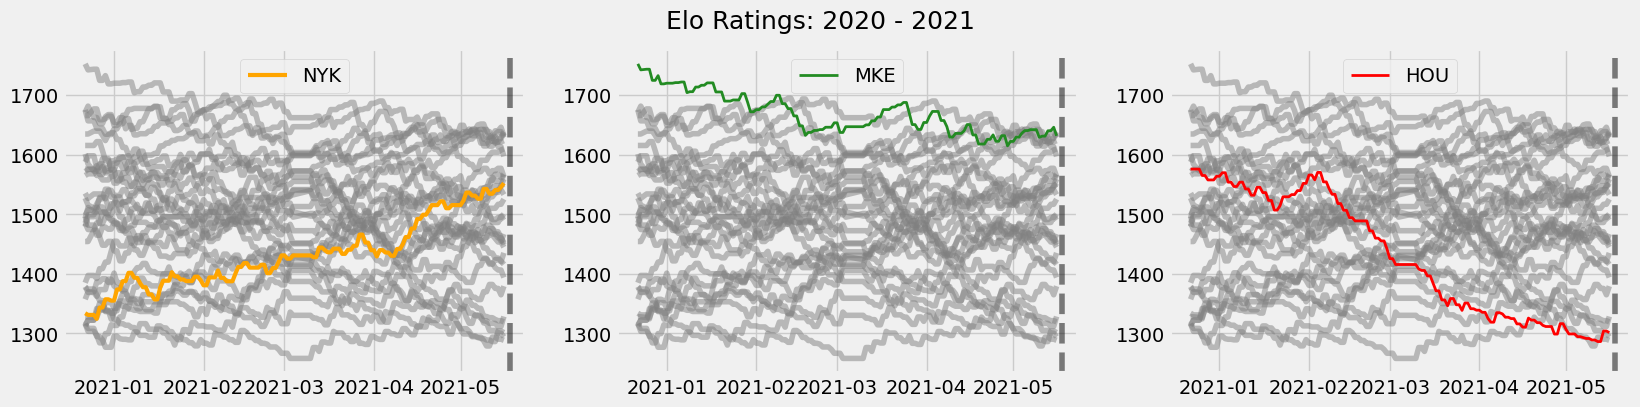

In [167]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

team = 'NewYork'

(
    final
    .query(f'team != "{team}"')
    .query('season == "2020-21"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax1
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='Orange',
        ax=ax1,
        label='NYK',
        lw=3
    )
)

team = 'Milwaukee'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax2
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='forestgreen',
        ax=ax2,
        label='MKE',
        lw=2
    )
)

ax1.set_xlabel('')
ax2.set_xlabel('')

team = 'Houston'

(
    final
    .query('season == "2020-21"')
    .query(f'team != "{team}"')
    .pivot_table(
        index='dt',
        columns='team',
        values='elo'
    )
    .plot(
        legend=False,
        color='grey',
        alpha=0.5,
        ax=ax3
    )
)

(
    final
    .query('season == "2020-21"')
    .query(f'team == "{team}"')
    .plot(
        x='dt',
        y='elo',
        color='red',
        ax=ax3,
        label='HOU',
        lw=2
    )
)

ax1.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax2.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax3.axvline(
    x=pendulum.Date(2021,5,18),
    ls='--',
    color='black',
    alpha=0.5
)

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')

plt.suptitle('Elo Ratings: 2020 - 2021', size=18)
plt.show()

## Is it Good?

Vegas and Elo batting averages, by season.

In [168]:
home_field_advantage = 100

scoreboard = (
    pd.DataFrame(rows)
    .assign(
        elo_diff = lambda x: x['home_elo'] - x['away_elo'] + home_field_advantage,
        winner = lambda x: x['home_mov'].transform(lambda s: 'Away' if s < 0 else 'Home'),
        
        vegas_prediction = lambda x: x['point_spread'].transform(lambda s: 'Home' if s < 0 else 'Away'),
        elo_prediction = lambda x: x['elo_diff'].transform(lambda s: 'Away' if s < 0 else 'Home'),
        
        vegas_correct = lambda x: x['winner'] == x['vegas_prediction'],
        elo_correct = lambda x: x['winner'] == x['elo_prediction']
        
    )
    .merge(
        (
            games
            [['season', 'game_id', 'game_number']]
            .drop_duplicates()
        ),
        on='game_id',
        how='left'
    )
)

scoreboard.tail(20)

,game_id,home,away,home_elo,away_elo,home_mov,point_spread,dt,home_elo__post,away_elo__post,elo_diff,winner,vegas_prediction,elo_prediction,vegas_correct,elo_correct,season,game_number
16919,d4d081054ab119583e3dc4862a102ef3,Nets,Atlanta,1522.462772,1510.358428,4,-7.0,2022-12-09,1530.031738,1503.004291,112.104344,Home,Home,Home,True,True,2022-23,27.0
16920,ac266b6ab35a4dbe33ea0bb5f27a43b3,NewOrleans,Phoenix,1551.327592,1635.572343,11,1.5,2022-12-09,1561.829114,1625.402068,15.755249,Home,Away,Home,False,True,2022-23,25.0
16921,c1a0626042b6e6fd7b8bc8d38f192afc,Orlando,Toronto,1294.590466,1538.261453,4,8.5,2022-12-09,1309.896481,1523.372702,-143.670987,Home,Away,Away,False,False,2022-23,27.0
16922,daec343d40932439249d1183ac4eba94,Philadelphia,LALakers,1551.334519,1426.287900,11,-5.0,2022-12-09,1556.062935,1421.659741,225.046619,Home,Home,Home,True,True,2022-23,25.0
16923,e6730803068407a5154632c40c31c856,Utah,Minnesota,1534.924978,1508.754490,-10,0.0,2022-12-09,1520.097157,1523.163740,126.170488,Away,Away,Home,True,False,2022-23,28.0
16924,5054b09e0b0fd3f82134bbbdcd14ae05,Chicago,Dallas,1474.676334,1576.442669,29,-5.0,2022-12-10,1485.732256,1565.736712,-1.766335,Home,Home,Away,True,False,2022-23,25.0
16925,3483d8c7f45d20aa4f8ef2b1136595ec,Cleveland,OklahomaCity,1502.450727,1393.697933,8,-4.5,2022-12-10,1507.536619,1388.725616,208.752794,Home,Home,Home,True,True,2022-23,27.0
16926,568cdce3b618ce074b46e10b0aa224c7,Denver,Utah,1562.366924,1520.097157,5,-11.5,2022-12-10,1569.098533,1513.545211,142.269767,Home,Home,Home,True,True,2022-23,26.0
16927,261b37a776c6022e07d21dea6540622e,GoldenState,Boston,1525.334593,1693.487539,16,2.5,2022-12-10,1538.465096,1680.759918,-68.152946,Home,Away,Away,False,False,2022-23,27.0
16928,4541d8a27f86846e408fc7238f8e6374,Indiana,Nets,1411.244546,1530.031738,-3,-8.5,2022-12-10,1400.838780,1540.109642,-18.787192,Away,Home,Away,False,True,2022-23,27.0


In [169]:
vegas_confusion = (
    scoreboard
    .groupby(['winner', 'vegas_prediction'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .pivot_table(
        index='vegas_prediction',
        columns='winner',
        values='games'
    )
)

display(Markdown('### Vegas Confusion Matrix'))
display(vegas_confusion)

elo_confusion = (
    scoreboard
    .groupby(['winner', 'elo_prediction'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .pivot_table(
        index='elo_prediction',
        columns='winner',
        values='games'
    )
)

display(Markdown('### Elo Confusion Matrix'))
display(elo_confusion)

### Vegas Confusion Matrix

winner,Away,Home
vegas_prediction,,
Away,3817,2081
Home,3240,7801


### Elo Confusion Matrix

winner,Away,Home
elo_prediction,,
Away,3077,1802
Home,3980,8080


In [170]:
batting_average__vegas = (
    scoreboard
    .groupby(['season', 'game_number', 'vegas_correct'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['season', 'vegas_correct'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['season', 'game_number'],
        columns='vegas_correct',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['season', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        ## Calculate Vegas batting average:
        Vegas = lambda x: 100 * x['correct'] / x['total']

    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['season', 'game_number', 'Vegas']]
)

batting_average__elo = (
    scoreboard
    .groupby(['season', 'game_number', 'elo_correct'])
    .agg(
        games = ('game_id', 'count')
    )
    .reset_index()
    .assign(
        cumulative_mean = lambda x: x.groupby(['season', 'elo_correct'])['games'].transform(lambda s: s.expanding().mean())
    )
    .pivot_table(
        index=['season', 'game_number'],
        columns='elo_correct',
        values='cumulative_mean'
    )
    .reset_index()
    .set_axis(['season', 'game_number', 'incorrect', 'correct'], axis=1)
    .assign(
        total = lambda x: x['incorrect'] + x['correct'],
        ## Calculate Elo batting average:
        Elo = lambda x: 100 * x['correct'] / x['total']

    )
    .query('game_number >= 20')
    .query('game_number <= 82')
    [['season', 'game_number', 'Elo']]
)

batting_averages = (
    batting_average__elo
    .merge(
        batting_average__vegas
    )
    .melt(
        id_vars=['season', 'game_number'],
        var_name='Predictor',
        value_name='Batting Average'
    )
)

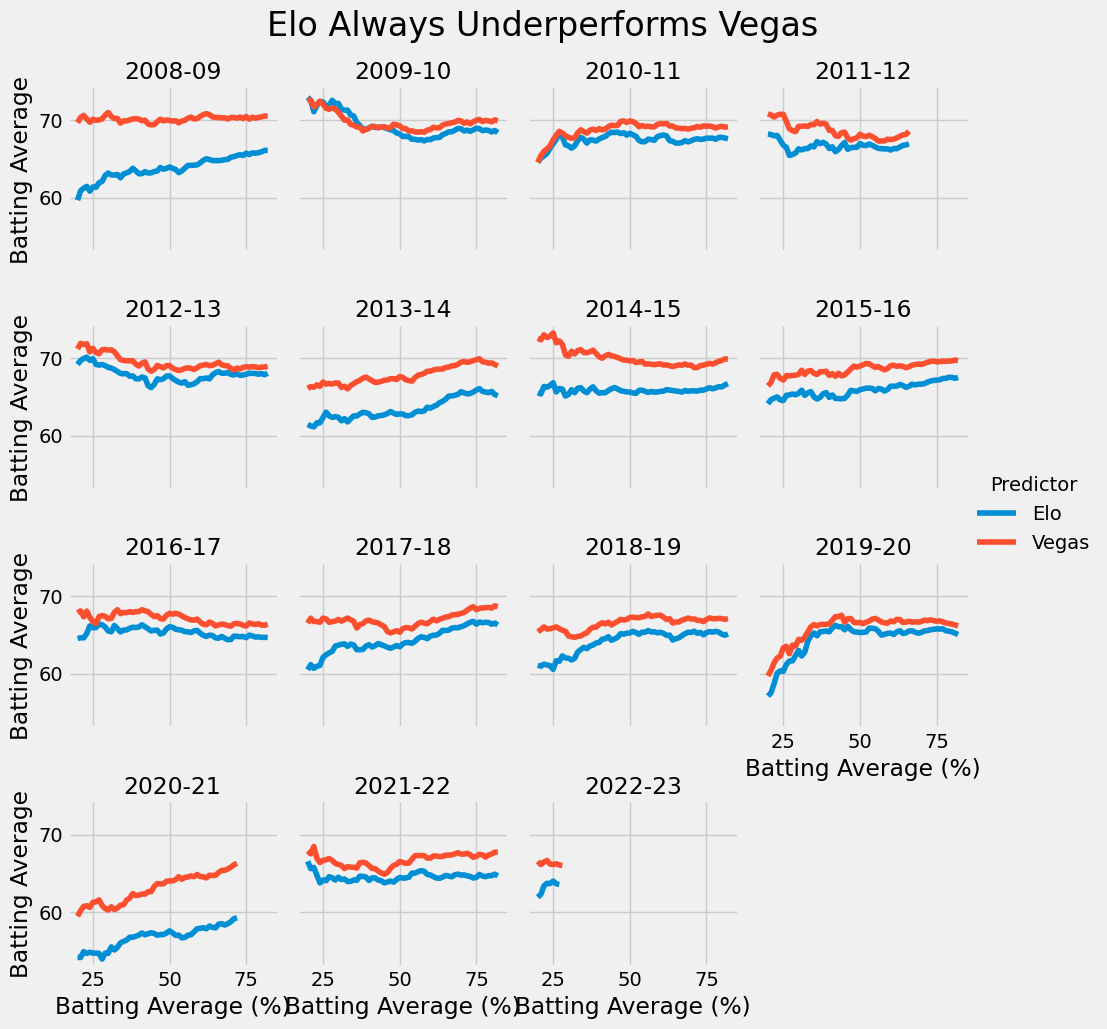

In [171]:
style.use('fivethirtyeight')

g = sns.relplot(
    data=batting_averages,
    x='game_number',
    y='Batting Average',
    hue='Predictor',
    col='season',
    col_wrap=4,
    kind='line',
    height=2.5,
    aspect=1
)

g.set_axis_labels("Batting Average (%)")
g.set_titles(col_template="{col_name}")

g.fig.suptitle('Elo Always Underperforms Vegas', y=1.03, size=24)

plt.show()

In [172]:
(
    batting_averages
    .query('game_number == 82')
    .pivot_table(
        index='season', 
        columns='Predictor', 
        values='Batting Average'
    )
    .round(1)
)

Predictor,Elo,Vegas
season,,
2008-09,66.1,70.5
2009-10,68.4,69.9
2010-11,67.6,69.1
2012-13,68.1,69.0
2013-14,65.2,69.0
2014-15,66.7,69.9
2015-16,67.5,69.7
2016-17,64.7,66.4
2017-18,66.3,68.7


In [173]:
(
    batting_averages
    .query('Predictor == "Elo"')
    .to_csv('../data/Elo Batting Averages.csv', index=False)
)

## Elo Model Performance

In [192]:
model_name = 'Base Elo'
seasons = scoreboard.season.unique().tolist()
response_variables = ['home_mov', 'point_spread']

model_results = []

for season in seasons:

    data = (
        scoreboard
        .query(f'season == "{season}"')
        .query('game_number >= 20')
        .query('game_number <= 82')
    )
    
    for response_variable in response_variables:
    

        X = data['elo_diff']
        y =  data[response_variable]

        model = sm.OLS(y, X)
        results = model.fit()

        row = results.params.to_dict().copy()
        row['rsquared'] = results.rsquared
        row['season'] = season
        row['response_variable'] = response_variable

        row['model_name'] = model_name

        row['batting_average'] = data['elo_correct'].mean()

        model_results.append(row)

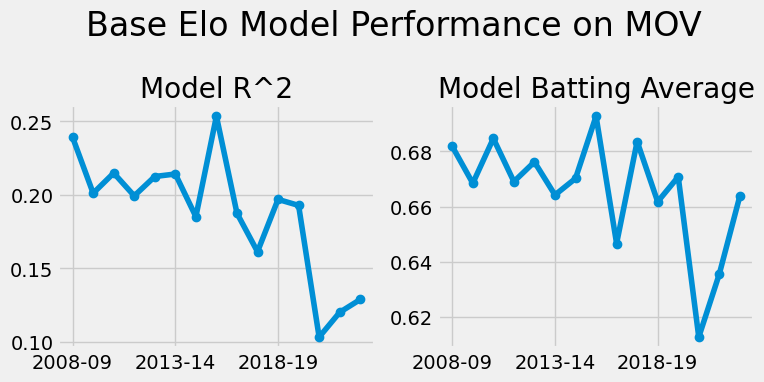

In [205]:
results = pd.DataFrame(model_results)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

(
    results
    .query('response_variable == "home_mov"')
    .plot(
        x='season',
        y='rsquared',
        ax=ax1,
        marker='o',
        legend=False,
        title='Model R^2'
    )
)

(
    results
    .query('response_variable == "home_mov"')
    .plot(
        x='season',
        y='batting_average',
        ax=ax2,
        marker='o',
        legend=False,
        title='Model Batting Average'
    )
)

plt.suptitle('Base Elo Model Performance on MOV', y=1.2, size=24)

ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()

In [206]:
results.to_csv('../data/Elo Results.csv', index=False)

## Vs Vegas

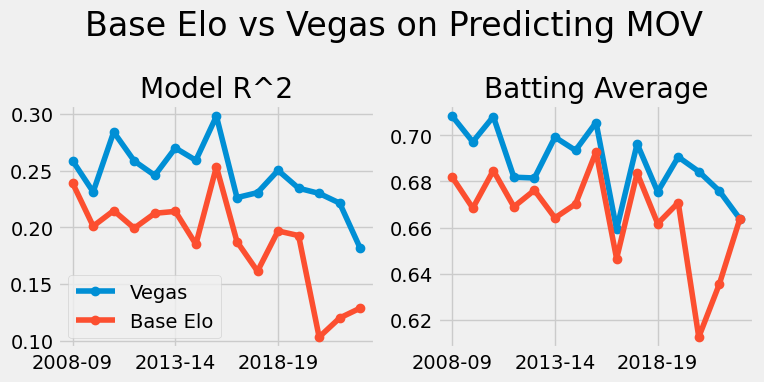

In [214]:
vs_vegas = (
    results
    .query('response_variable == "home_mov"')
    .melt(
        id_vars=['season'],
        value_vars=['rsquared', 'batting_average'],
        value_name='Base Elo',
        var_name='feature_name'
    )
    .merge(
        pd.read_csv('../data/Vegas Benchmarks.csv'),
        on=['season', 'feature_name']
    )
)


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,3))

(
    vs_vegas
    .query('feature_name == "rsquared"')
    .plot(
        x='season',
        y=['Vegas', 'Base Elo'],
        ax=ax1,
        marker='o',
        legend=True,
        title='Model R^2'
    )
)

(
    vs_vegas
    .query('feature_name == "batting_average"')
    .plot(
        x='season',
        y=['Vegas', 'Base Elo'],
        ax=ax2,
        marker='o',
        legend=False,
        title='Batting Average'
    )
)

plt.suptitle('Base Elo vs Vegas on Predicting MOV', y=1.2, size=24)

ax1.set_xlabel('')
ax2.set_xlabel('')
plt.show()